# TBP SKIN CANCER DETECTION using DNNs / AdaBoost / CatBoost / XGBoost / Light GBR

## Importing Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE, SVMSMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, auc, roc_auc_score, classification_report, confusion_matrix
import xgboost as xgb
from catboost import CatBoostClassifier
import lightgbm as lgb
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.base import BaseEstimator, TransformerMixin
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import tensorflow as tf
from sklearn.svm import SVC

2024-07-30 18:01:15.666496: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-30 18:01:15.666655: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-30 18:01:15.814744: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import os
root_dir = '/kaggle/input'

for item in os.listdir(root_dir):
    item_path = os.path.join(root_dir, item)
    if os.path.isdir(item_path):
        print(f"Folder: {item}")
        for filename in os.listdir(item_path):
            file_path = os.path.join(item_path, filename)
            if os.path.isfile(file_path):
                print(file_path)
    elif os.path.isfile(item_path):
        print(item_path)
        
!ls /kaggle/input/isic-2024-challenge

Folder: isic-2024-challenge
/kaggle/input/isic-2024-challenge/sample_submission.csv
/kaggle/input/isic-2024-challenge/train-metadata.csv
/kaggle/input/isic-2024-challenge/test-metadata.csv
/kaggle/input/isic-2024-challenge/test-image.hdf5
/kaggle/input/isic-2024-challenge/train-image.hdf5
sample_submission.csv  test-metadata.csv  train-image.hdf5
test-image.hdf5        train-image	  train-metadata.csv


## Basic Data Exploration

In [3]:
df = pd.read_csv('/kaggle/input/isic-2024-challenge/train-metadata.csv', low_memory=False)
df.replace([float('inf'), float('-inf')], pd.NA, inplace=True)
df.drop_duplicates(inplace=True)
df.head()

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510


In [4]:
positive_eg = df[df['target'] == 1]
negative_eg = df[df['target'] == 0]

final_test_df = pd.concat([positive_eg.copy()[:25], negative_eg.copy()[:25]]).reset_index().drop(columns = ['index'])


positive_eg = positive_eg.copy()[26:]
negative_eg = negative_eg.copy()[218::1000]

#negative_eg = negative_eg.copy()[51:]

df = pd.concat([positive_eg, negative_eg]).reset_index().drop(columns = ['index'])

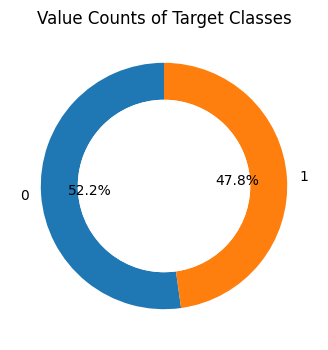

In [5]:
dist = df.target.value_counts()

plt.figure(figsize=(4, 4))
plt.pie(dist.values, labels=dist.index.astype(str), autopct='%1.1f%%', startangle=90, wedgeprops=dict(width=0.3))

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Value Counts of Target Classes')
plt.show()

In [6]:
df_test = pd.read_csv('/kaggle/input/isic-2024-challenge/test-metadata.csv', low_memory=False)
df_test

,isic_id,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,tbp_lv_Aext,...,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,attribution,copyright_license
0,ISIC_0015657,IP_6074337,45.0,male,posterior torso,2.70,TBP tile: close-up,3D: XP,22.80433,20.007270,...,0.304827,1.281532,2.299935,0.479339,20,-155.06510,1511.222000,113.980100,Memorial Sloan Kettering Cancer Center,CC-BY
1,ISIC_0015729,IP_1664139,35.0,female,lower extremity,2.52,TBP tile: close-up,3D: XP,16.64867,9.657964,...,0.000000,1.271940,2.011223,0.426230,25,-112.36924,629.535889,-15.019287,"Frazer Institute, The University of Queensland...",CC-BY
2,ISIC_0015740,IP_7142616,65.0,male,posterior torso,3.16,TBP tile: close-up,3D: XP,24.25384,19.937380,...,0.230742,1.080308,2.705857,0.366071,110,-84.29282,1303.978000,-28.576050,FNQH Cairns,CC-BY


## Preprocessing Pipeline

In [7]:
df['tbp_lv_location_simple'] = df['tbp_lv_location_simple'].replace('Unknown', np.nan)

In [8]:
feature_counts = df['iddx_full'].value_counts()

top_5_features = feature_counts.nlargest(5).index

df['iddx_full'] = df['iddx_full'].apply(lambda x: x if x in top_5_features else 'generic')

df['iddx_full'] = df['iddx_full'].replace(np.nan, 'generic')

In [9]:
columns_to_drop = [
    'patient_id', 'iddx_2', 'iddx_3', 'iddx_4', 'iddx_5', 
    'mel_mitotic_index', 'mel_thick_mm', 'tbp_tile_type','lesion_id', 
    'attribution', 'copyright_license', 'image_type', 'isic_id','tbp_lv_dnn_lesion_confidence'
]

num_cols = [
    'age_approx', 'clin_size_long_diam_mm', 'tbp_lv_A', 'tbp_lv_Aext', 
    'tbp_lv_B', 'tbp_lv_Bext', 'tbp_lv_C', 'tbp_lv_Cext', 'tbp_lv_H', 
    'tbp_lv_Hext', 'tbp_lv_L', 'tbp_lv_Lext', 'tbp_lv_areaMM2', 
    'tbp_lv_area_perim_ratio', 'tbp_lv_color_std_mean', 'tbp_lv_deltaA', 
    'tbp_lv_deltaB', 'tbp_lv_deltaL', 'tbp_lv_deltaLB', 'tbp_lv_deltaLBnorm', 
    'tbp_lv_eccentricity', 'tbp_lv_minorAxisMM', 'tbp_lv_nevi_confidence', 
    'tbp_lv_norm_border', 'tbp_lv_norm_color', 'tbp_lv_perimeterMM', 
    'tbp_lv_radial_color_std_max', 'tbp_lv_stdL', 'tbp_lv_stdLExt', 
    'tbp_lv_symm_2axis', 'tbp_lv_x', 'tbp_lv_y', 'tbp_lv_z'
]

cat_cols = ['iddx_full', 'iddx_1',
    'sex', 'anatom_site_general', 
    'tbp_lv_location', 'tbp_lv_location_simple', 
    'tbp_lv_symm_2axis_angle'
]

df.drop(columns=columns_to_drop, inplace=True)

In [10]:
target = list(df.target)

In [11]:
df['iddx_1'].value_counts()

iddx_1
Benign       401
Malignant    367
Name: count, dtype: int64

In [12]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, k=20):
        self.k = k
        self.selector = None

    def fit(self, X, y):
        self.selector = SelectKBest(score_func=f_classif, k=self.k)
        self.selector.fit(X, y)
        return self

    def transform(self, X):
        return X[:, self.selector.get_support(indices=True)]

    def get_feature_names_out(self, feature_names):
        return [feature_names[i] for i in self.selector.get_support(indices=True)]

class ColumnRenamer(BaseEstimator, TransformerMixin):
    def __init__(self, feature_names):
        self.feature_names = feature_names

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return pd.DataFrame(X, columns=self.feature_names)

# Assuming num_cols and cat_cols are defined
pipeline = Pipeline(steps=[
    ('preprocessor', ColumnTransformer(
        transformers=[
            ('num', Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='mean')),
                ('scaler', StandardScaler())
            ]), num_cols),
            ('cat', Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('onehot', OneHotEncoder(handle_unknown='ignore'))
            ]), cat_cols)
        ]
    )),
    ('feature_selector', FeatureSelector(k=50)),
    ('column_renamer', ColumnRenamer([]))
])

X = df[num_cols + cat_cols]
y = df['target']

pipeline.fit(X, y)
preprocessor = pipeline.named_steps['preprocessor']
feature_selector = pipeline.named_steps['feature_selector']

feature_names = preprocessor.get_feature_names_out()

selected_feature_names = feature_selector.get_feature_names_out(feature_names)

pipeline.named_steps['column_renamer'].feature_names = selected_feature_names

X_reduced = pipeline.transform(X)

X_reduced_df = pd.DataFrame(X_reduced, columns=selected_feature_names)
X_reduced_df['target'] = y.values

X_reduced_df.head()

/opt/conda/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw


,num__age_approx,num__clin_size_long_diam_mm,num__tbp_lv_A,num__tbp_lv_Aext,num__tbp_lv_B,num__tbp_lv_Bext,num__tbp_lv_C,num__tbp_lv_Cext,num__tbp_lv_H,num__tbp_lv_Hext,...,cat__tbp_lv_location_Left Leg - Upper,cat__tbp_lv_location_Right Leg - Upper,cat__tbp_lv_location_Torso Back Top Third,cat__tbp_lv_location_Unknown,cat__tbp_lv_location_simple_Head & Neck,cat__tbp_lv_location_simple_Torso Back,cat__tbp_lv_symm_2axis_angle_105,cat__tbp_lv_symm_2axis_angle_120,cat__tbp_lv_symm_2axis_angle_145,target
0,-1.105718,0.823319,-0.840950,-1.115814,0.289449,-0.169134,-0.221145,-0.667165,1.031180,1.049660,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.435830,0.543382,2.083471,0.394337,-0.471346,-0.214674,0.879880,-0.020250,-1.883781,-0.511729,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1
2,0.821217,1.188182,2.104800,1.977676,-0.563824,0.254710,0.843940,1.222135,-1.979255,-1.438056,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1
3,0.050443,-0.978974,3.229137,3.720481,0.270703,0.201869,2.032036,2.335894,-1.867792,-2.497713,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
4,0.821217,3.713909,-1.320000,1.412432,-2.033582,-0.522549,-2.162348,0.349597,-0.853836,-1.573039,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1


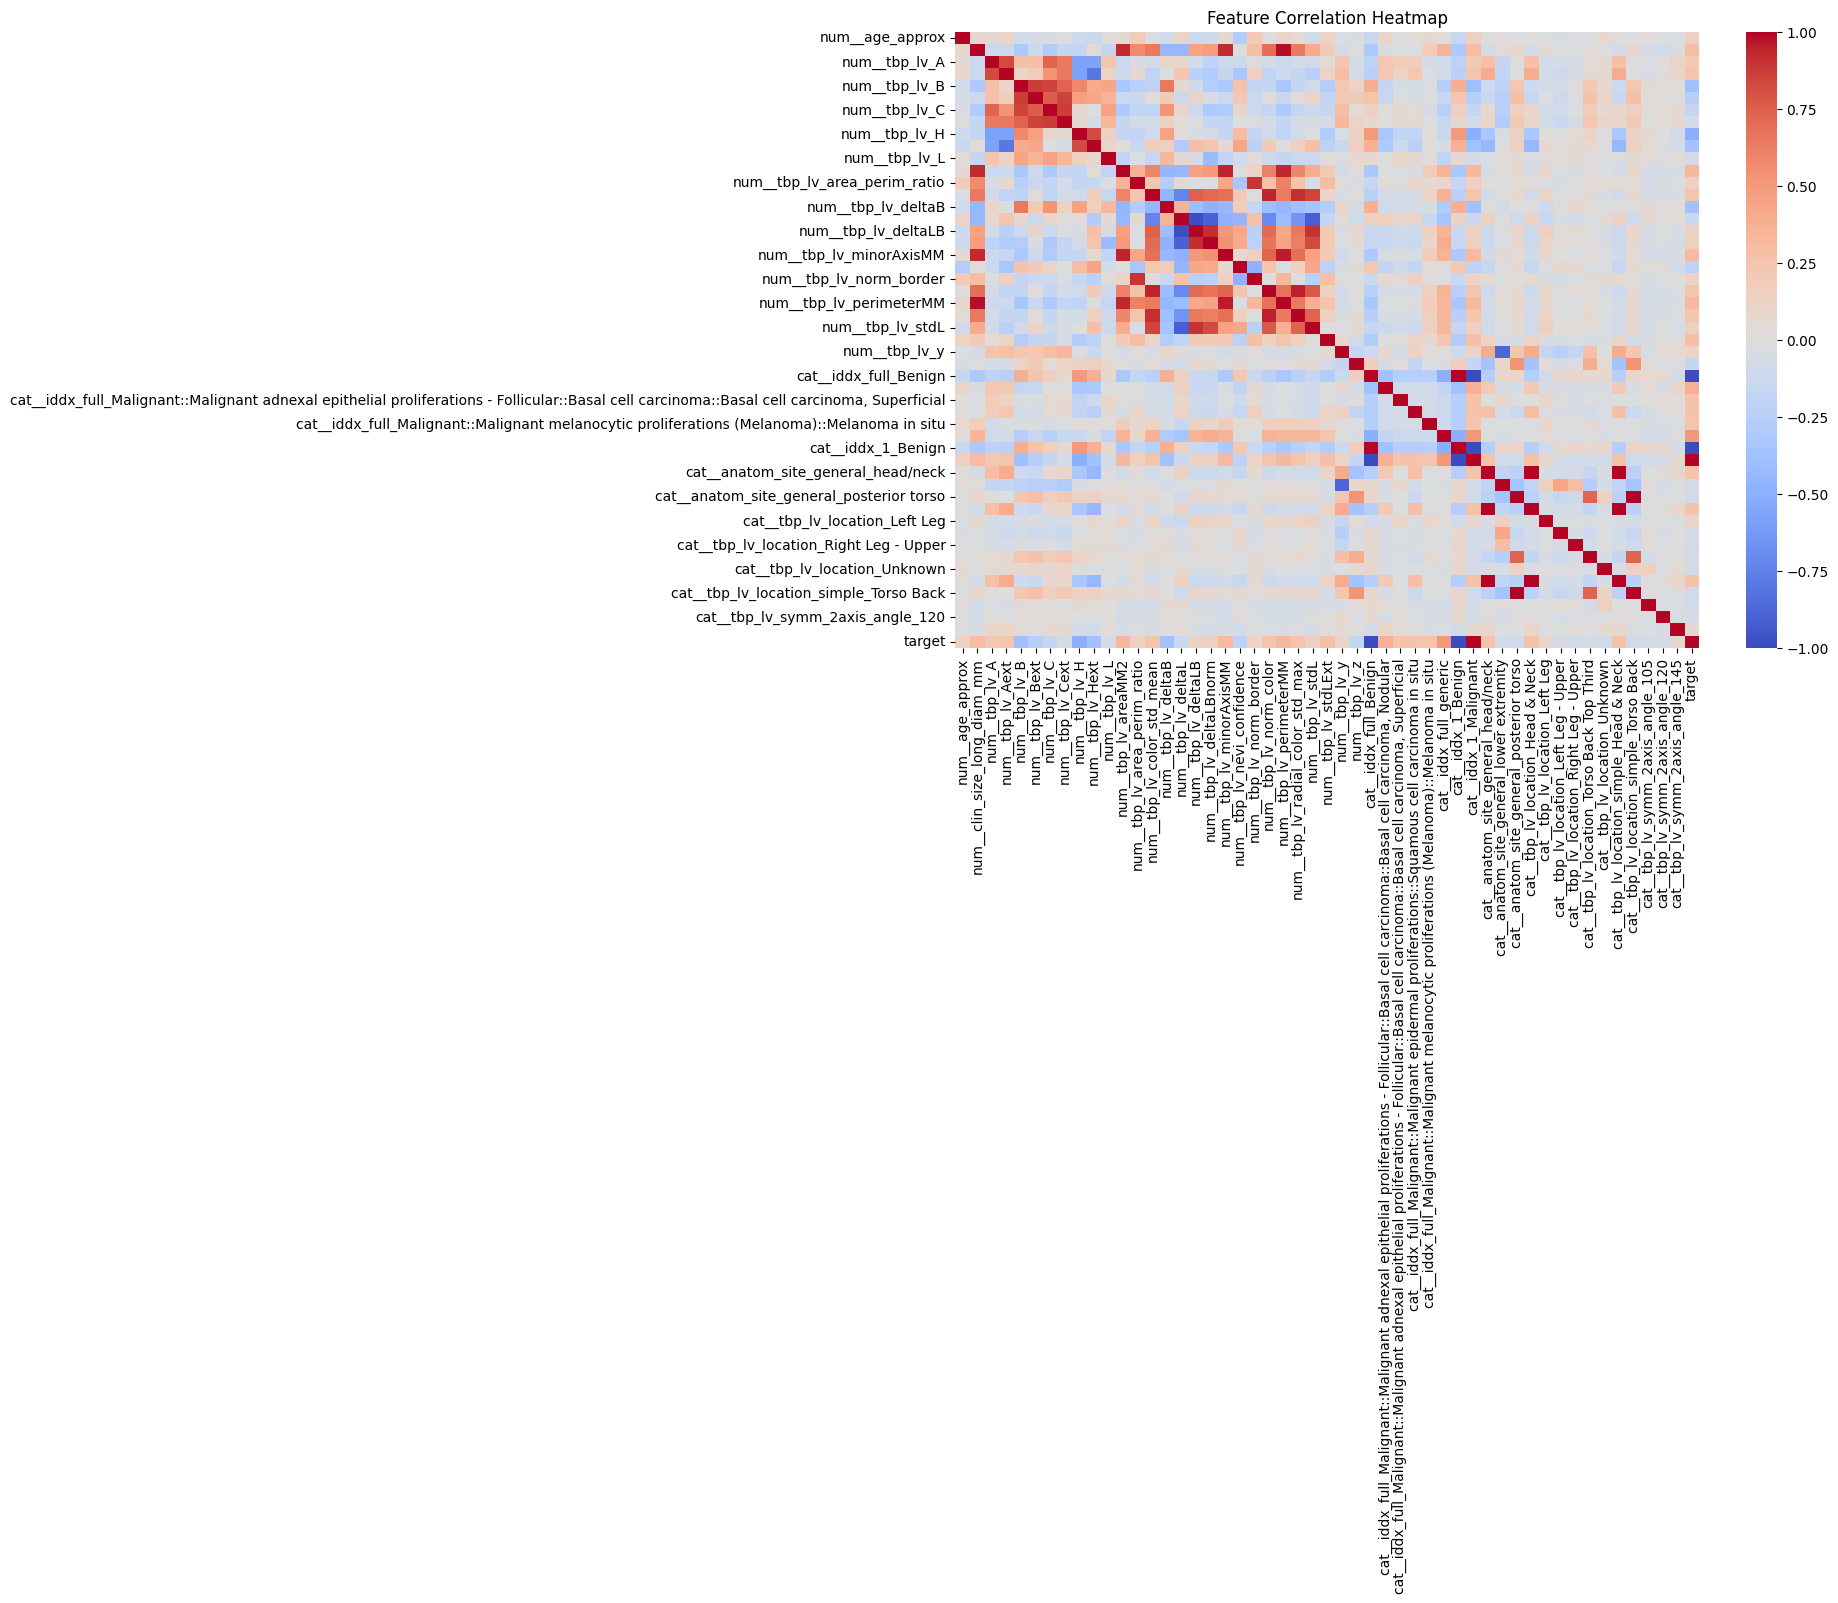

In [13]:
plt.figure(figsize=(12, 8))
correlation_matrix = X_reduced_df.corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()


## Augementing Data using SMOTE


In [14]:
df = X_reduced_df

In [15]:
X = df.drop(columns=['target'])
y = df['target']

rus = SVMSMOTE(sampling_strategy='auto', random_state=42, k_neighbors=10)

X_resampled, y_resampled = rus.fit_resample(X, y)

df_resampled = pd.DataFrame(X_resampled, columns=X.columns)
df_resampled['target'] = y_resampled
df_resampled.drop_duplicates(inplace = True)

df = X_reduced_df

## Creating Modeling Structure

In [16]:
base_features = ['num__clin_size_long_diam_mm', 'num__tbp_lv_A', 'num__tbp_lv_Aext',
       'num__tbp_lv_B', 'num__tbp_lv_Bext', 'num__tbp_lv_H',
       'num__tbp_lv_Hext', 'num__tbp_lv_areaMM2',
       'num__tbp_lv_area_perim_ratio', 'num__tbp_lv_color_std_mean',
       'num__tbp_lv_deltaB', 'num__tbp_lv_minorAxisMM',
       'num__tbp_lv_nevi_confidence', 'num__tbp_lv_norm_color',
       'num__tbp_lv_perimeterMM', 'num__tbp_lv_radial_color_std_max',
       'num__tbp_lv_stdL', 'num__tbp_lv_stdLExt', 'num__tbp_lv_z',
       'cat__anatom_site_general_head/neck',
       'cat__tbp_lv_location_Head & Neck',
       'cat__tbp_lv_location_simple_Head & Neck']

immediate_features = ['cat__iddx_full_Benign',
'cat__iddx_full_Malignant::Malignant adnexal epithelial proliferations - Follicular::Basal cell carcinoma::Basal cell carcinoma, Nodular',
'cat__iddx_full_Malignant::Malignant adnexal epithelial proliferations - Follicular::Basal cell carcinoma::Basal cell carcinoma, Superficial',
'cat__iddx_full_Malignant::Malignant epidermal proliferations::Squamous cell carcinoma in situ',
'cat__iddx_full_Malignant::Malignant melanocytic proliferations (Melanoma)::Melanoma in situ',
'cat__iddx_full_generic', 
'cat__iddx_1_Benign', 
'cat__iddx_1_Malignant']

target_features = ['target']

In [17]:
df_1 = X_reduced_df[base_features + [immediate_features[0]]]
df_2 = X_reduced_df[base_features + [immediate_features[1]]]
df_3 = X_reduced_df[base_features + [immediate_features[2]]]
df_4 = X_reduced_df[base_features + [immediate_features[3]]]
df_5 = X_reduced_df[base_features + [immediate_features[4]]]
df_6 = X_reduced_df[base_features + [immediate_features[5]]]
df_7 = X_reduced_df[base_features + [immediate_features[6]]]
df_8 = X_reduced_df[base_features + [immediate_features[7]]]

col = list(range(df_1.shape[1] - 1)) + ['target']
df_1.columns = col
df_2.columns = col
df_3.columns = col
df_4.columns = col
df_5.columns = col
df_6.columns = col
df_7.columns = col
df_8.columns = col

df_f = X_reduced_df[immediate_features + target_features]
col = list(range(df_f.shape[1] - 1)) + ['target']
df_f.columns = col

base_dfs = [df_1, df_2, df_3, df_4, df_5, df_6, df_7, df_8]

## Applying Models

In [18]:
pAUCscores = []
confMatrix = []
cfReport = []

In [19]:
class ParticipantVisibleError(Exception):
    pass

def score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str, min_tpr: float=0.80) -> float:
    del solution[row_id_column_name]
    del submission[row_id_column_name]

    if not pd.api.types.is_numeric_dtype(submission.values):
        raise ParticipantVisibleError('Submission target column must be numeric')

    v_gt = abs(np.asarray(solution.values) - 1)
    v_pred = -1.0 * np.asarray(submission.values)

    max_fpr = abs(1 - min_tpr)

    fpr, tpr, _ = roc_curve(v_gt, v_pred, sample_weight=None)
    if max_fpr is None or max_fpr == 1:
        return auc(fpr, tpr)
    if max_fpr <= 0 or max_fpr > 1:
        raise ValueError("Expected min_tpr in range [0, 1), got: %r" % min_tpr)

    stop = np.searchsorted(fpr, max_fpr, "right")
    x_interp = [fpr[stop - 1], fpr[stop]]
    y_interp = [tpr[stop - 1], tpr[stop]]
    tpr = np.append(tpr[:stop], np.interp(max_fpr, x_interp, y_interp))
    fpr = np.append(fpr[:stop], max_fpr)
    partial_auc = auc(fpr, tpr)

    return partial_auc


### Applying LightGBM

In [20]:
%%capture
def LightGBM(df: pd.DataFrame, save=False):
    X = df.drop(columns=['target'])
    y = df['target']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=42)

    lgb_model = lgb.LGBMClassifier()
    lgb_model.fit(X_train, y_train)
    y_scores = lgb_model.predict_proba(X_test)[:, 1]
    y_pred = (y_scores > 0.5).astype(int)
    solution = pd.DataFrame({'row_id': range(len(y_test)), 'target': y_test})
    submission = pd.DataFrame({'row_id': range(len(y_scores)), 'prediction': y_scores})
    pAUC = score(solution, submission, 'row_id', min_tpr=0.80)
    if save:
        pAUCscores.append(pAUC)
        confMatrix.append(confusion_matrix(y_test, y_pred))
        cfReport.append(classification_report(y_test, y_pred))
    
    return lgb_model, pAUC

### Applying XGBoost

In [21]:
def XGBoost(df: pd.DataFrame, save=False):
    X = df.drop(columns=['target'])
    y = df['target']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', verbose=3)
    xgb_model.fit(X_train, y_train)

    y_scores = xgb_model.predict_proba(X_test)[:, 1]
    y_pred = (y_scores > 0.5).astype(int)
    solution = pd.DataFrame({'row_id': range(len(y_test)), 'target': y_test})
    submission = pd.DataFrame({'row_id': range(len(y_scores)), 'prediction': y_scores})
    pAUC = score(solution, submission, 'row_id', min_tpr=0.80)
    if save:
        pAUCscores.append(pAUC)
        confMatrix.append(confusion_matrix(y_test, y_pred))
        cfReport.append(classification_report(y_test, y_pred))

    return [xgb_model, pAUC]

### Apply CATBoost

In [22]:
 def CATBoost(df:pd.DataFrame, save=False):
    X = df.drop(columns=['target'])
    y = df['target']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    catboost_model = CatBoostClassifier(verbose=0)
    catboost_model.fit(X_train, y_train)

    y_scores = catboost_model.predict_proba(X_test)[:, 1]
    y_pred = (y_scores > 0.5).astype(int)
    solution = pd.DataFrame({'row_id': range(len(y_test)), 'target': y_test})
    submission = pd.DataFrame({'row_id': range(len(y_scores)), 'prediction': y_scores})
    pAUC = score(solution, submission, 'row_id', min_tpr=0.80)
    if save:
        pAUCscores.append(pAUC)
        confMatrix.append(confusion_matrix(y_test, y_pred))
        cfReport.append(classification_report(y_test, y_pred))

    return [catboost_model, pAUC]

### Applying RF

In [23]:
def RandomForest(df:pd.DataFrame, save=False):
    X = df.drop(columns=['target'])
    y = df['target']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    random_forest_model = RandomForestClassifier(random_state=42, verbose=3)
    random_forest_model.fit(X_train, y_train)

    y_scores = random_forest_model.predict_proba(X_test)[:, 1]
    y_pred = (y_scores > 0.5).astype(int)
    solution = pd.DataFrame({'row_id': range(len(y_test)), 'target': y_test})
    submission = pd.DataFrame({'row_id': range(len(y_scores)), 'prediction': y_scores})
    pAUC = score(solution, submission, 'row_id', min_tpr=0.80)
    if save:
        pAUCscores.append(pAUC)
        confMatrix.append(confusion_matrix(y_test, y_pred))
        cfReport.append(classification_report(y_test, y_pred))

    
    return [random_forest_model,pAUC]

### Using Deep Neural Networks

In [24]:
def DNNetworks(df:pd.DataFrame, save=False):
    X = df.drop(columns=['target'])
    y = df['target']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train.shape[1],), ),
        Dense(128, activation='relu', ),
        Dense(32, activation='relu', ),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])

    history = model.fit(X_train, y_train, epochs=15, validation_split=0.2, batch_size=32, verbose=4)
    loss, accuracy = model.evaluate(X_test, y_test)

    y_pred = (model.predict(X_test) > 0.5).astype("int32")
    y_true = y_test

    y_scores = model.predict(X_test).flatten()

    solution = pd.DataFrame({'row_id': range(len(y_true)), 'target': y_true})
    submission = pd.DataFrame({'row_id': range(len(y_scores)), 'prediction': y_scores})

    pAUC = score(solution, submission, 'row_id', min_tpr=0.80)

    if save:
        pAUCscores.append(pAUC)
        confMatrix.append(confusion_matrix(y_true, y_pred))
        cfReport.append(classification_report(y_true, y_pred))
    return [model,pAUC]

## Base Models

In [25]:
%%capture

base_mdls = []
pc = []
for i in tqdm(base_dfs, desc="Processing DataFrames"):
    temp_mdls = []
    pAUCs = []
    t = LightGBM(i)
    temp_mdls.append(t[0])
    pAUCs.append(t[1])
    t = XGBoost(i)
    temp_mdls.append(t[0])
    pAUCs.append(t[1])
    t = CATBoost(i)
    temp_mdls.append(t[0])
    pAUCs.append(t[1])
    t = RandomForest(i)
    temp_mdls.append(t[0])
    pAUCs.append(t[1])
    t = DNNetworks(i)
    temp_mdls.append(t[0])
    pAUCs.append(t[1])
    
    max_index = pAUCs.index(max(pAUCs))
    best_model = temp_mdls[max_index]
    base_mdls.append(best_model)
    pc.append(max(pAUCs))
cb = CATBoost(df_f)[0]

In [26]:
pc

[0.15807663410969192,
 0.10338319088319085,
 0.10124434389140269,
 0.13303167420814477,
 0.06255924170616112,
 0.10430107526881717,
 0.15807663410969192,
 0.15774605559729524]

## Overall Metrics

In [27]:
def predict(test_data: pd.DataFrame, pipeline: Pipeline, model_1:list, model_2) -> pd.DataFrame:
    isic_id = test_data['isic_id']
    
    test_data['tbp_lv_location_simple'] = test_data['tbp_lv_location_simple'].replace('Unknown', np.nan)
    
    test_data['iddx_1'] = None
    test_data['iddx_full'] = None
    
    test_data_processed = pipeline.transform(test_data)
    
    feature_names = pipeline.named_steps['feature_selector'].get_feature_names_out(
        pipeline.named_steps['preprocessor'].get_feature_names_out())
        
    test_data_processed_df = pd.DataFrame(test_data_processed, columns=feature_names)
    
    df__1 = test_data_processed_df[base_features]
    col = list(range(df__1.shape[1]))
    df__1.columns = col
    
    try:
        l1 = model_1[0].predict_proba(df__1)[:, 1]
        l2 = model_1[1].predict_proba(df__1)[:, 1]
        l3 = model_1[2].predict_proba(df__1)[:, 1]
        l4 = model_1[3].predict_proba(df__1)[:, 1]
        l5 = model_1[4].predict_proba(df__1)[:, 1]
        l6 = model_1[5].predict_proba(df__1)[:, 1]
        l7 = model_1[6].predict_proba(df__1)[:, 1]
        l8 = model_1[7].predict_proba(df__1)[:, 1]
    except:
        l1 = model_1[0].predict(df__1).flatten()
        l2 = model_1[1].predict(df__1).flatten()
        l3 = model_1[2].predict(df__1).flatten()
        l4 = model_1[3].predict(df__1).flatten()
        l5 = model_1[4].predict(df__1).flatten()
        l6 = model_1[5].predict(df__1).flatten()
        l7 = model_1[6].predict(df__1).flatten()
        l8 = model_1[7].predict(df__1).flatten()
    
    df__f = pd.DataFrame({0:l1, 1:l2, 2:l3, 3:l4, 4:l5, 5:l6, 6:l7, 7:l8})
    try:
        test_predictions = model_2.predict_proba(df__f)[:, 1]
    except:
        test_predictions = model_2.predict(df__f).flatten()
        
    predictions_df = pd.DataFrame({'isic_id': isic_id, 'target': test_predictions})
    
    return predictions_df

In [28]:
X = final_test_df.drop(columns = ['target'])
y = final_test_df['target']

predicted_df = predict(X, pipeline, base_mdls, cb)

predicted_df['actual_target'] = y
solution = pd.DataFrame({'row_id': range(len(predicted_df['actual_target'])), 'target': predicted_df['actual_target']})
submission = pd.DataFrame({'row_id': range(len(predicted_df['target'])), 'prediction': predicted_df['target']})
pAUC = score(solution, submission, 'row_id', min_tpr=0.80)
print(pAUC)

0.0733333333333333


[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    0.0s


In [29]:
for ps, conf, cf, md in zip(pAUCscores, confMatrix, cfReport, _):
    print('----------------------------------')
    print('Metrics for', md)
    print('pAUC Score:\n', ps)
    print('Confusion Matrix:\n', conf)
    print('Other Metrics Report:\n', cf)

## Evaluating Score pAUC (without submission)

In [30]:
test_data = pd.read_csv('/kaggle/input/isic-2024-challenge/test-metadata.csv', low_memory=False)
predicted_df = predict(test_data, pipeline, base_mdls, cb)
predicted_df.to_csv('submission.csv', index=False)
predicted_df

[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    0.0s


,isic_id,target
0,ISIC_0015657,0.000504
1,ISIC_0015729,0.000504
2,ISIC_0015740,0.000504
